In [38]:
import rospy
import ros_numpy
from sensor_msgs.msg import Image as ImageMsg
from PIL import Image
from IPython.display import display
from lang_sam import LangSAM
import matplotlib.pyplot as plt
import numpy as np

In [39]:
rospy.init_node('collect_images', anonymous=True)

In [59]:
rgb_message = rospy.wait_for_message("camera/color/image_raw", ImageMsg)
depth_message = rospy.wait_for_message("/camera/aligned_depth_to_color/image_raw", ImageMsg)
rgb_data = ros_numpy.numpify(rgb_message)
depth_data = ros_numpy.numpify(depth_message)

In [54]:
print(rgb_data.shape)
print(depth_data.shape)

(720, 1280, 3)
(720, 1280)


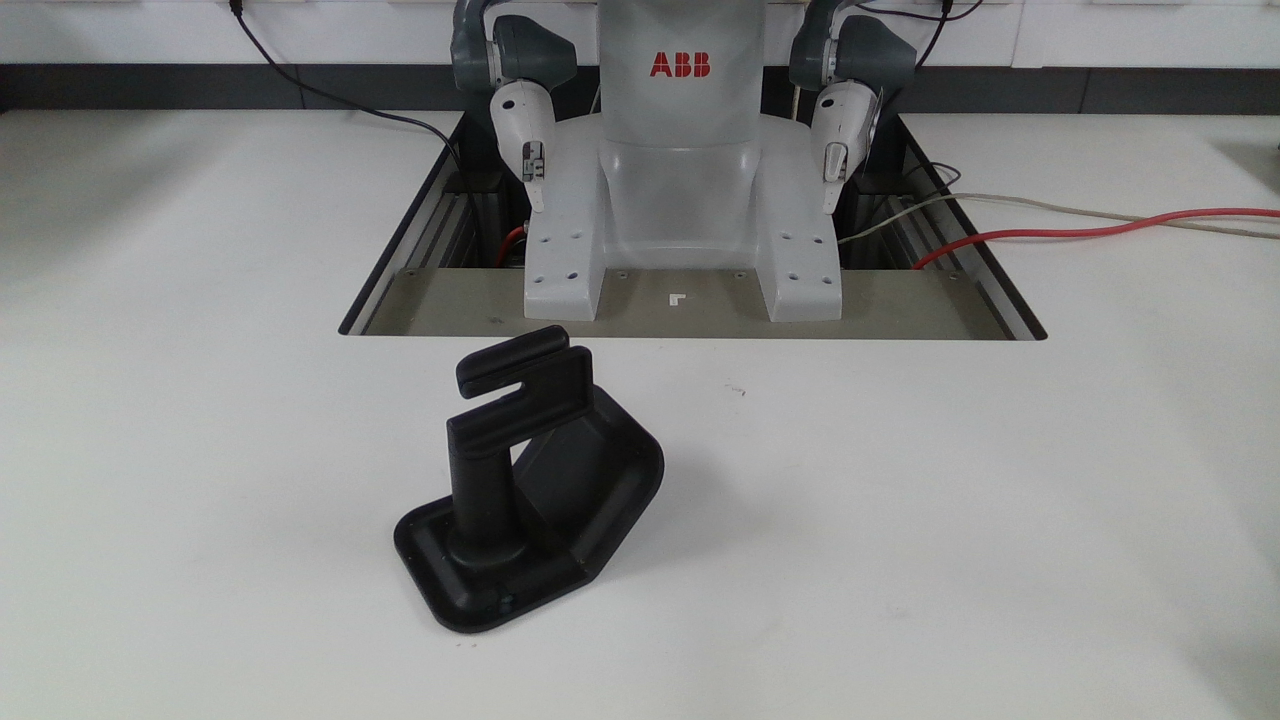

In [60]:
rgb_image = Image.fromarray(rgb_data)
rgb_image

In [61]:
depth_image = Image.fromarray(depth_data)

In [62]:
rgb_image.save("data/demo_spray_rgb.png")
depth_image.save("data/demo_spray_depth.png")

In [50]:
model = LangSAM()

final text_encoder_type: bert-base-uncased
Model loaded from /home/yilong/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [51]:
def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

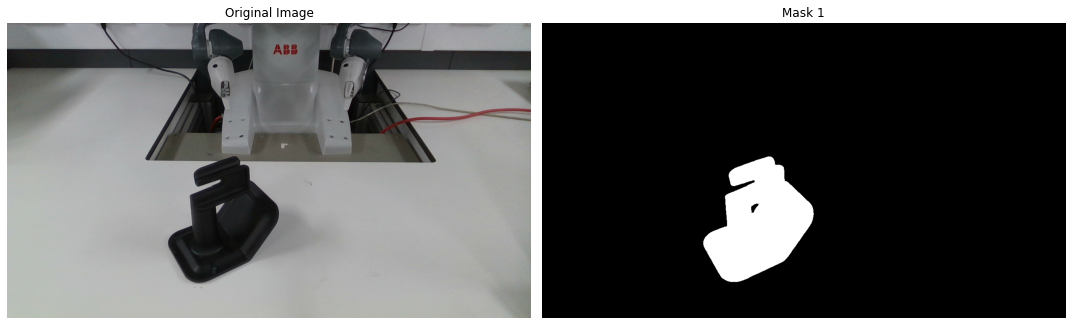

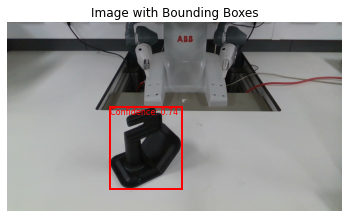

Bounding Boxes:
Box 1: tensor([392.3310, 323.9876, 666.1956, 634.4173])

Detected Phrases:
Phrase 1: black _ object

Confidence:
Logit 1: 0.738835334777832


In [63]:
image_pil = rgb_image.copy()
text_prompt = "black_object"
masks, boxes, phrases, logits = model.predict(rgb_image, text_prompt)

if len(masks) == 0:
    print(f"No objects of the '{text_prompt}' prompt detected in the image.")
else:
    # Convert masks to numpy arrays
    masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

    # Display the original image and masks side by side
    display_image_with_masks(image_pil, masks_np)

    # Display the image with bounding boxes and confidence scores
    display_image_with_boxes(image_pil, boxes, logits)

    # Save the masks
    for i, mask_np in enumerate(masks_np):
        mask_path = f"demo_spray_mask_{i+1}.png"
        save_mask(mask_np, mask_path)

    # Print the bounding boxes, phrases, and logits
    print_bounding_boxes(boxes)
    print_detected_phrases(phrases)
    print_logits(logits)


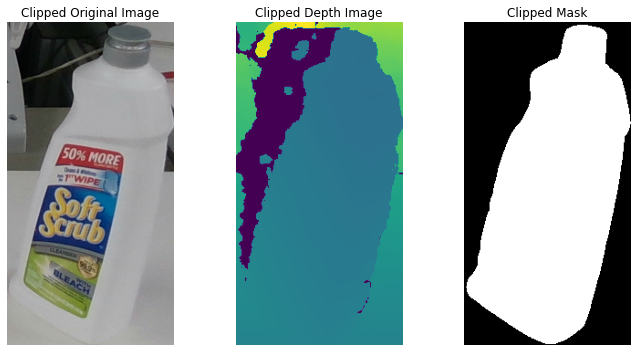

In [9]:
# Method to clip and save the bounding box from the original image
def save_clipped_box(image, box, filename):
    x_min, y_min, x_max, y_max = map(int, box)
    clipped_image = image.crop((x_min, y_min, x_max, y_max))
    clipped_image.save(filename)
    return clipped_image


# Method to clip and save the bounding box from the segmentation mask
def save_clipped_mask(mask_np, box, filename):
    x_min, y_min, x_max, y_max = map(int, box)
    clipped_mask = mask_np[y_min:y_max, x_min:x_max]
    save_mask(clipped_mask, filename)
    return clipped_mask

clipped_image_pil = save_clipped_box(image_pil, boxes[0], "data/clipped_image_live.png")
clipped_depth_pil = save_clipped_box(depth_image, boxes[0], "data/clipped_depth_live.png")
clipped_masks_np = save_clipped_mask(mask_np, boxes[0], "data/clipped_mask_live.png")

# Displaying the images using matplotlib

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display clipped original image
ax[0].imshow(clipped_image_pil)
ax[0].set_title("Clipped Original Image")
ax[0].axis('off')

# Display clipped depth image
ax[1].imshow(clipped_depth_pil)
ax[1].set_title("Clipped Depth Image")
ax[1].axis('off')

# Display clipped mask
# We're using a colormap to show the mask clearly
ax[2].imshow(clipped_masks_np, cmap='gray')
ax[2].set_title("Clipped Mask")
ax[2].axis('off')
plt.tight_layout()

plt.show()